<a href="https://colab.research.google.com/github/Ni7070/Aptos2019-Kaggle/blob/master/Aptos2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset


import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

import os
from os import path
import shutil
import glob

In [2]:
!pip install kaggle

In [11]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 4.2 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=c40630928956103d0797506d22223557f651b4acd09c4565b90f0c8dc8983131
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [12]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"tahiranishat","key":"e77773ea2b99fffa75a6e88b211f38b4"}'}

In [13]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [16]:
!kaggle competitions download -c aptos2019-blindness-detection

100% 9.51G/9.51G [03:32<00:00, 64.1MB/s]
100% 9.51G/9.51G [03:32<00:00, 48.1MB/s]


In [17]:
from zipfile import ZipFile
file_name = "aptos2019-blindness-detection.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print("Done!")

Done!


In [19]:
#read CSV files only filename and digit column
trainCSV =pd.read_csv('/content/train.csv', usecols = ['id_code', 'diagnosis'])
testCSV = pd.read_csv('/content/train.csv', usecols = ['id_code'])

In [20]:
TRAIN_PATH = "trainSet"
PATH = '/content/'

In [31]:
class aptos(Dataset):
    def __init__(self, merged_csv_file, root_dir, transform=None):
        self.data = merged_csv_file
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        path = self.root_dir + '/' + item[0] + '.png'
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [32]:
mean = [0.5,]
std = [0.5, ]

dset_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    
])
'''
LOADING DATASET
'''
dataset = aptos(merged_csv_file = trainCSV, root_dir = '/content/train_images', 
                            #train=True, 
                            transform = dset_transform # Normalize the image to [0-1] from [0-255]
                            )

In [33]:
#split data into train:test = 90:10
from sklearn.model_selection import train_test_split
train_dataset, test_dataset = train_test_split(dataset, test_size=0.1)

In [41]:
# Hyperparameters for settings3 accuracy = 95.7973809765506%
batch_size = 256
num_iters = 4000
input_dim = 28*28 # num_features = 784
num_hidden = 180
output_dim = 10

learning_rate = 0.002

num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)


# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True
                                           )  

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False) 

class NeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 
        self.linear_1 = nn.Linear(784, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.LeakyReLU()

        ### 2nd hidden layer: 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.leaky_relu_1 = nn.ReLU6()

        ### 3rd hidden layer: 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.ReLU6()

        ### 4th hidden layer: 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.sigmoid = nn.Sigmoid()

        ### Output layer: 
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ## 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.leaky_relu_1(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)

        ### 4th hidden layer
        out  = self.linear_4(out)
        ### Non-linearity in 3rd hidden layer
        out = self.sigmoid(out)
        
        # Linear layer (output)
        #probas  = self.linear_out(out)
        logits  = self.linear_out(out)
        probas = F.softmax(logits, dim=1)
        return probas

model = NeuralNetworkModel(input_size = input_dim,
                           num_classes = output_dim,
                           num_hidden = num_hidden)
# To enable GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
p = []
l = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images.float()) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1
        # print(iter)

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images.float())

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)

                pt = predicted.cpu()
                lt = labels.cpu()
                #taking all predicted label into a list
                p.append(pt)
                #taking all real label into a list
                l.append(lt)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 1.9691014289855957. Accuracy: 50.95367847411444
Iteration: 1000. Loss: 1.8236654996871948. Accuracy: 68.11989100817439
Iteration: 1500. Loss: 1.7532826662063599. Accuracy: 70.29972752043597
Iteration: 2000. Loss: 1.7951089143753052. Accuracy: 68.39237057220708
Iteration: 2500. Loss: 1.7910895347595215. Accuracy: 70.29972752043597
Iteration: 3000. Loss: 1.785598635673523. Accuracy: 70.02724795640327
Iteration: 3500. Loss: 1.7296124696731567. Accuracy: 70.84468664850137
Iteration: 4000. Loss: 1.7398898601531982. Accuracy: 70.57220708446866


[1.9691014289855957, 1.8236654996871948, 1.7532826662063599, 1.7951089143753052, 1.7910895347595215, 1.785598635673523, 1.7296124696731567, 1.7398898601531982]


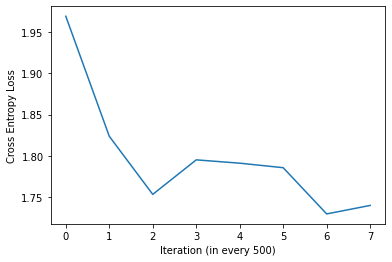

In [42]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

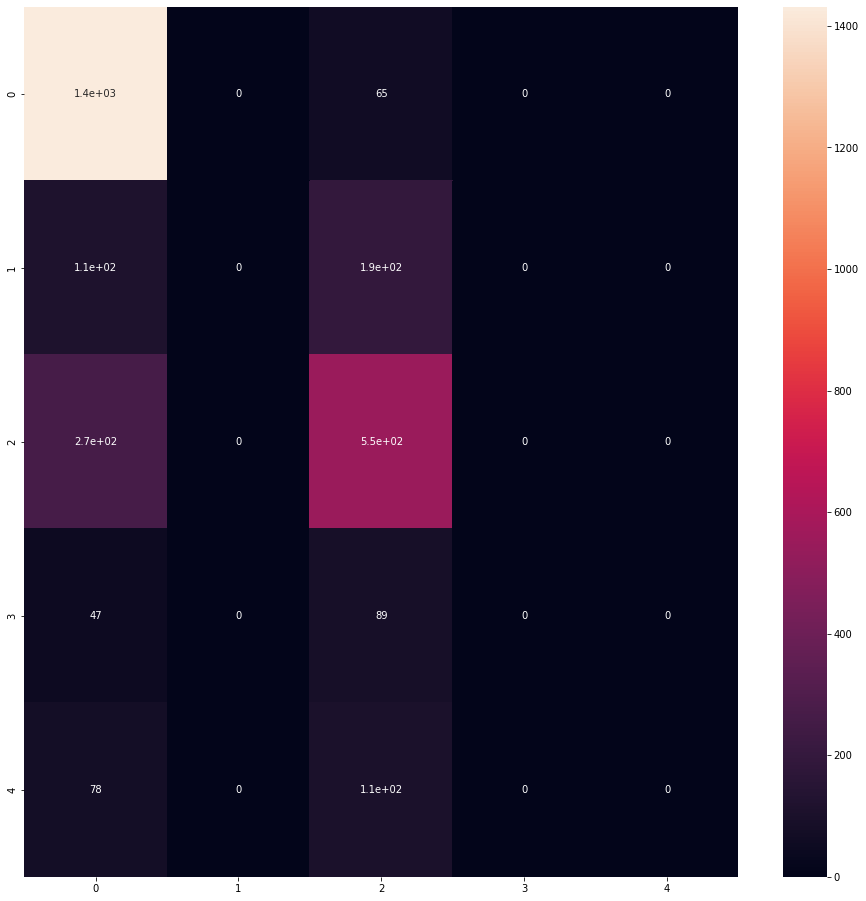

In [43]:
import itertools
import seaborn as sns


#flatten predicted labels and real labels
flatten_l = list(itertools.chain.from_iterable(l))
flatten_p = list(itertools.chain.from_iterable(p))

fig, ax = plt.subplots(figsize=(16, 16))
from sklearn.metrics import confusion_matrix
# Confusion matrix
conf_mat=confusion_matrix(flatten_l, flatten_p)
# print(conf_mat)
sns.heatmap(conf_mat, annot=True)

In [44]:
from sklearn.metrics import classification_report
print(classification_report(flatten_l, flatten_p))

              precision    recall  f1-score   support

           0       0.74      0.96      0.83      1496
           1       0.00      0.00      0.00       304
           2       0.55      0.67      0.60       816
           3       0.00      0.00      0.00       136
           4       0.00      0.00      0.00       184

    accuracy                           0.67      2936
   macro avg       0.26      0.33      0.29      2936
weighted avg       0.53      0.67      0.59      2936



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [46]:
root_path = '/content/gdrive/MyDrive/Colab Notebooks/pickle Files'

In [48]:
save_model = True

if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), root_path + 'aptos2019_1.pkl') 

In [49]:
save_model = True

if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(model.state_dict(), root_path + 'aptos2019_1.pkl') 

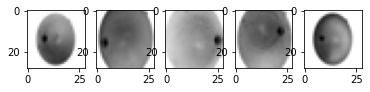

In [50]:
for images, labels in test_loader:
    break
    
fig, ax = plt.subplots(1, 5)
for i in range(5):
    ax[i].imshow(images[i].view(28, 28), cmap=matplotlib.cm.binary)

plt.show()

In [52]:
predictions = model.forward(images[:5].view(-1, 28*28).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions.cpu().numpy())

Predicted labels [0 2 0 2 0]
